In [54]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

## load inputs

In [3]:
INPUT_FILE = "cities.csv"

In [44]:
cities = pd.read_csv(INPUT_FILE)
cities.head()

,CityId,X,Y
0,0,316.836739,2202.340707
1,1,4377.405972,336.602082
2,2,3454.158198,2820.053011
3,3,4688.099298,2935.898056
4,4,1010.696952,3236.750989


In [45]:
cities.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 197769 entries, 0 to 197768
Data columns (total 3 columns):
CityId    197769 non-null int64
X         197769 non-null float64
Y         197769 non-null float64
dtypes: float64(2), int64(1)
memory usage: 4.5 MB


In [46]:
nb_cities = cities.count()['CityId']
print('Nb cities: ', nb_cities)

Nb cities:  197769


## Add prime numbers to the data

In [47]:
def prime_generator(max_n):
    """Generate the list of all prime numbers until max_n
        (Sieve of Erathosthenes' method)
    """
    # define a map to record for each non prime integer
    # which prime numbers can divide it
    D = {}
    # running integer that is checked for primeness
    q = 2
    while q < max_n:
        if q not in D:
            # q is prime
            yield q
            # mark q**2 as non prime
            D[q*q] = [q]
        else:
            # q is composite, and D[q] the list of primes
            # that divide it. Mark the mnext multiples
            for p in D[q]:
                D.setdefault(p+q, []).append(p)
            del D[q]
            
        q = q+1

In [48]:
list(prime_generator(50))

[2, 3, 5, 7, 11, 13, 17, 19, 23, 29, 31, 37, 41, 43, 47]

In [49]:
# generate the set of all primes <= nb_cities
all_primes = set(prime_generator(nb_cities))

In [50]:
cities['is_prime'] = cities['CityId'].apply(lambda x: int(x in all_primes))

In [51]:
cities.head()

,CityId,X,Y,is_prime
0,0,316.836739,2202.340707,0
1,1,4377.405972,336.602082,0
2,2,3454.158198,2820.053011,1
3,3,4688.099298,2935.898056,1
4,4,1010.696952,3236.750989,0


Save the augmented data to the disk

In [53]:
cities.to_csv('aug_cities.csv', index=False)

## Data visualization

In [57]:
# select all prime cities
prime_cities = cities[cities['is_prime'] == 1]

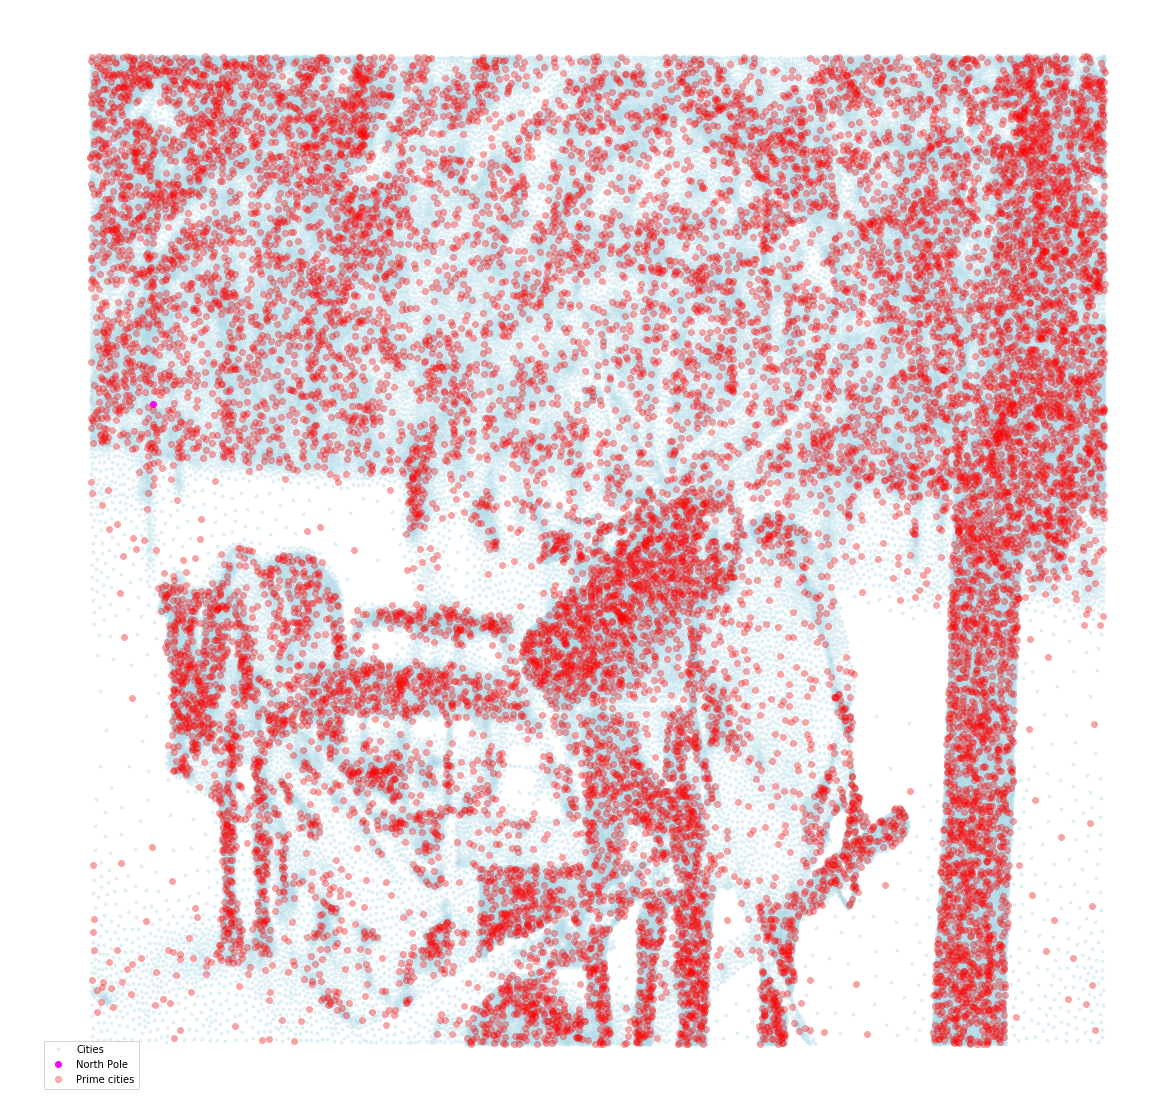

In [60]:
fig = plt.figure(figsize=(20,20))
plt.plot(cities.X, cities.Y, '.', color='lightblue', alpha=0.3, label='Cities')
plt.plot(cities.X[0], cities.Y[0], 'o',color='fuchsia', label='North Pole')
plt.plot(prime_cities.X, prime_cities.Y, 'o',color='red', alpha=0.3, label='Prime cities')
plt.axis('off')
plt.legend();

## Calculate the distance of a tour

In [114]:
import timeit
import math
import functools

In [66]:
# convert the data to efficient numpy arrays
X = cities.X.values
Y = cities.Y.values
primes = cities.is_prime.values

Naive implementation

In [111]:
def distance_naive(X, Y, primes):
    """Calculate the tour distance - Naive implementation
    
    Args:
        X (numpy.ndarray): X coordinates
        Y (numpy.ndarray): Y coordinates
        primes (numpy.ndarray): 0 or 1
    
    Returns:
        float: total distance
    
    """
    # add the north pole at the end of the arrays to get back there
    X = np.append(X, X[0])
    Y = np.append(Y, Y[0])
    primes = np.append(primes, primes[0])
    total = 0
    for i in range(1, len(X)):
        local_dist = math.sqrt((X[i]-X[i-1])**2+(Y[i]-Y[i-1])**2)
        # add a penality
        if i % 10 == 0:
            if not bool(primes[i]):
                local_dist = 1.1*local_dist
        total += local_dist
    return total

In [107]:
distance_naive(X, Y, primes)

447881519.34148186

Vectorized implementation

In [104]:
def distance(X, Y, primes):
    """Calculate the tour distance - Optimized implementation
    
    Args:
        X (numpy.ndarray): X coordinates
        Y (numpy.ndarray): Y coordinates
        primes (numpy.ndarray): 0 or 1
    
    Returns:
        float: total distance
    
    """
    distances = np.hypot(X-np.roll(X, shift=-1), Y-np.roll(Y, shift=-1))
    penalties = 0.1*distances[9::10]*(1-primes[9::10])
    return np.sum(distances)+np.sum(penalties)

In [108]:
(distance(X, Y, primes) - distance_naive(X, Y, primes))/distance_naive(X, Y, primes)

-0.002226284803489561

### compare the two implementations for 100 runs

In [126]:
naive_distance_cal = functools.partial(distance_naive, X=X, Y=Y, primes=primes)
#
timeit.timeit("naive_distance_cal()", setup="from __main__ import naive_distance_cal", number=100)

92.7003626666667

In [127]:
opti_distance_cal = functools.partial(distance, X=X, Y=Y, primes=primes)
#
timeit.timeit("opti_distance_cal()", setup="from __main__ import opti_distance_cal", number=100)

1.157599573333414